In [1]:
import numpy as np

# Data preprocessing
X = np.load("rainfall_data.npy")  # np.array with shape (370, 265). It's a 2D grid of rainfall values.
X = np.nan_to_num(X[::4, ::4])  # Subsample by a factor of 4 to speed up processing.
X = np.fliplr(X)  # Some flipping required
X = np.rot90(X)
x, y = np.meshgrid(np.arange(X.shape[1]), np.arange(X.shape[0]))

non_zero_mask = X != 0
X = X[non_zero_mask]
x = x[non_zero_mask]
y = y[non_zero_mask]

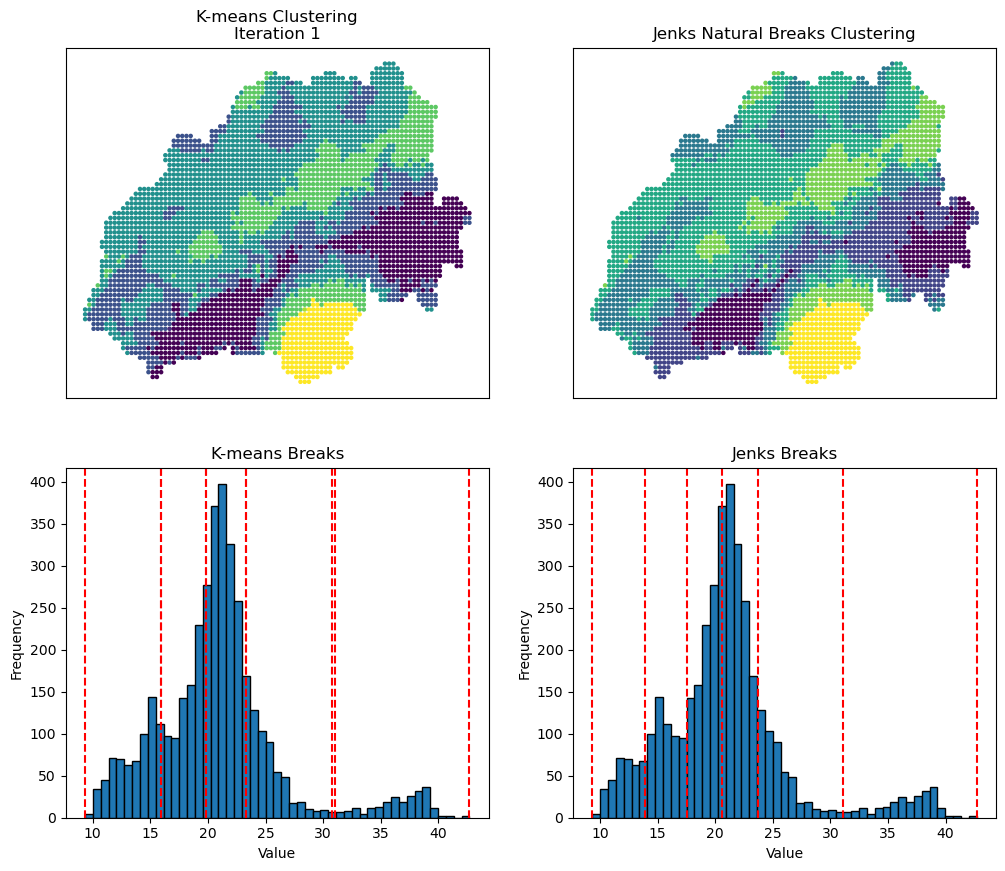

In [2]:
from sklearn.cluster import KMeans
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import BoundaryNorm
from jenkspy import jenks_breaks

include_jenks = True

iterations = 50
n_clusters = 5
centroids = None

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
scat1 = ax1.scatter(x, y, c=X, s=5)
scat2 = ax2.scatter(x, y, c=X, s=5)
cmap = plt.get_cmap('viridis')
scat1.set_cmap(cmap)
scat2.set_cmap(cmap)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])

# Jenks natural breaks
boundaries_jenks = jenks_breaks(X, n_clusters+1)
norm_jenks = BoundaryNorm(boundaries_jenks, cmap.N)
scat2.set_norm(norm_jenks)
ax2.set_title('Jenks Natural Breaks Clustering')

def animate(i):
    global centroids
    # K-means
    kmeans = KMeans(
        max_iter=1,
        n_init=1,
        init=(centroids if centroids is not None else 'random'),
        n_clusters=n_clusters,
        random_state=1)
    kmeans.fit(X.reshape(-1, 1))
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    kmeans_breaks = []
    for cluster_id in range(6):
        cluster_data = X[labels == cluster_id]
        if len(cluster_data) > 0:
            cluster_min = np.min(cluster_data)
            cluster_max = np.max(cluster_data)
            kmeans_breaks.append(cluster_min)
            kmeans_breaks.append(cluster_max)
    kmeans_breaks = np.sort(kmeans_breaks)
    boundaries_kmeans = kmeans_breaks
    norm_kmeans = BoundaryNorm(boundaries_kmeans, cmap.N)
    scat1.set_norm(norm_kmeans)
    ax1.set_title(f'K-means Clustering\nIteration {i+1}')

    # Histograms
    ax3.clear()
    ax3.hist(X, bins=np.linspace(X.min(), X.max(), 50), edgecolor='black')
    for b in boundaries_kmeans:
        ax3.axvline(b, linestyle='--', color='r')
    ax3.set_title('K-means Breaks')
    ax3.set_xlabel('Value')
    ax3.set_ylabel('Frequency')

    ax4.clear()
    ax4.hist(X, bins=np.linspace(X.min(), X.max(), 50), edgecolor='black')
    for b in boundaries_jenks:
        ax4.axvline(b, linestyle='--', color='r')
    ax4.set_title('Jenks Breaks')
    ax4.set_xlabel('Value')
    ax4.set_ylabel('Frequency')

    return scat1, scat2, ax3, ax4

ani = animation.FuncAnimation(fig, animate, repeat=False, frames=iterations)
writer = animation.PillowWriter(fps=7, metadata=dict(artist='Ivo Gasparini'), bitrate=1800)
ani.save('output/clustering.gif', writer=writer)
plt.savefig('output/clustering_last.png')
plt.show()

In [3]:
from sklearn import metrics

def compute_cluster_metrics(X, labels):
    """
    Compute cluster evaluation metrics for the given data and cluster labels.
    """
    silhouette_score = metrics.silhouette_score(X, labels)
    calinski_harabasz_score = metrics.calinski_harabasz_score(X, labels)
    davies_bouldin_score = metrics.davies_bouldin_score(X, labels)

    print(f"Silhouette Score: {silhouette_score:.3f}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz_score:.3f}")
    print(f"Davies-Bouldin Score: {davies_bouldin_score:.3f}")

jenks_breaks = jenks_breaks(X, n_clusters+1)
jenks_labels = np.digitize(X, jenks_breaks)
print("Jenks Natural Breaks Clustering Metrics:")
compute_cluster_metrics(X.reshape(-1, 1), jenks_labels)
print()

kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X.reshape(-1, 1))
kmeans_labels = kmeans.labels_
print("K-means Clustering Metrics:")
compute_cluster_metrics(X.reshape(-1, 1), kmeans_labels)

Jenks Natural Breaks Clustering Metrics:
Silhouette Score: 0.534
Calinski-Harabasz Score: 14704.851
Davies-Bouldin Score: 0.469

K-means Clustering Metrics:
Silhouette Score: 0.553
Calinski-Harabasz Score: 15467.218
Davies-Bouldin Score: 0.486


- Silhouette Score: This metric measures how well each data point fits into its assigned cluster, compared to other clusters. Higher values (closer to 1) indicate better-defined clusters.

- Calinski-Harabasz Score: This metric evaluates the ratio of the sum of between-cluster dispersion and the sum of within-cluster dispersion. Higher values indicate better clustering performance.

- Davies-Bouldin Score: This metric calculates the average similarity between each cluster and its most similar cluster. Lower values indicate better cluster separation.